# Goal

The goal of this notebook is to use previously fitted/made dataset of sensors datasets, combine it with the generators dataset to predict an the amount of production at a given time with given Irradiations.

Same as before, 2nd plant's data will be used as testing data.

In [1]:
# Importing related datasets

import pandas as pd

# Import custom sensors' sets 
sens_df = pd.read_parquet("dataset/parquets/plant_1_updated_sensor")

# Import generator's sets
gen_df = pd.read_csv("dataset/Plant_1_Generation_Data.csv")

In [3]:
# Cleaning data

sens_df

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,date,time,time_id
0,2020-05-15 00:00:00,25.184316,22.857507,0.0,2020-05-15,00:00:00,0
1,2020-05-16 00:00:00,22.659000,20.571000,0.0,2020-05-16,00:00:00,0
2,2020-05-17 00:00:00,24.170166,21.631490,0.0,2020-05-17,00:00:00,0
3,2020-05-18 00:00:00,21.155691,20.599400,0.0,2020-05-18,00:00:00,0
4,2020-05-19 00:00:00,22.610982,20.609906,0.0,2020-05-19,00:00:00,0
...,...,...,...,...,...,...,...
3260,2020-06-13 23:45:00,22.205029,20.459212,0.0,2020-06-13,23:45:00,95
3261,2020-06-14 23:45:00,23.418154,22.447845,0.0,2020-06-14,23:45:00,95
3262,2020-06-15 23:45:00,23.641211,23.051286,0.0,2020-06-15,23:45:00,95
3263,2020-06-16 23:45:00,22.892004,21.216600,0.0,2020-06-16,23:45:00,95


In [5]:
gen_df

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0
...,...,...,...,...,...,...,...
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0


First issue: Need to merge both datasets but nb of rows not matching 
How to solve? We just need to transform our generation dataset with our values of irradiation and the time_id (at least), the rest are not really useful

Second issues: We have multiple modules on this datasets
How to solve? For this set and future testing (with Plant 2) including the source_key as input will only lead to imprecision.
If we wanted to predict on the same plant for future, we could keep the source key, which would give us more precision.
But given the way I'll test my models (As to see if close plants/set of modules can get predicted with close accuracy when trained on the other) 

In [3]:
# Transforming datasets

gen_df = gen_df.drop(columns=["SOURCE_KEY", "PLANT_ID", "DC_POWER", "TOTAL_YIELD", "DAILY_YIELD"])
gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], format='%d-%m-%Y %H:%M')
gen_df

,DATE_TIME,AC_POWER
0,2020-05-15 00:00:00,0.0
1,2020-05-15 00:00:00,0.0
2,2020-05-15 00:00:00,0.0
3,2020-05-15 00:00:00,0.0
4,2020-05-15 00:00:00,0.0
...,...,...
68773,2020-06-17 23:45:00,0.0
68774,2020-06-17 23:45:00,0.0
68775,2020-06-17 23:45:00,0.0
68776,2020-06-17 23:45:00,0.0


In [4]:
sens_df = sens_df.drop(columns=["AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE","time", "date"])
sens_df

,DATE_TIME,IRRADIATION,time_id
0,2020-05-15 00:00:00,0.0,0
1,2020-05-16 00:00:00,0.0,0
2,2020-05-17 00:00:00,0.0,0
3,2020-05-18 00:00:00,0.0,0
4,2020-05-19 00:00:00,0.0,0
...,...,...,...
3260,2020-06-13 23:45:00,0.0,95
3261,2020-06-14 23:45:00,0.0,95
3262,2020-06-15 23:45:00,0.0,95
3263,2020-06-16 23:45:00,0.0,95


In [6]:
merge_df = gen_df.merge(sens_df, on="DATE_TIME")
merge_df

,DATE_TIME,AC_POWER,IRRADIATION,time_id
0,2020-05-15 00:00:00,0.0,0.0,0
1,2020-05-15 00:00:00,0.0,0.0,0
2,2020-05-15 00:00:00,0.0,0.0,0
3,2020-05-15 00:00:00,0.0,0.0,0
4,2020-05-15 00:00:00,0.0,0.0,0
...,...,...,...,...
68773,2020-06-17 23:45:00,0.0,0.0,95
68774,2020-06-17 23:45:00,0.0,0.0,95
68775,2020-06-17 23:45:00,0.0,0.0,95
68776,2020-06-17 23:45:00,0.0,0.0,95


In [7]:
merge_df = merge_df.drop(columns=["DATE_TIME"])
merge_df

,AC_POWER,IRRADIATION,time_id
0,0.0,0.0,0
1,0.0,0.0,0
2,0.0,0.0,0
3,0.0,0.0,0
4,0.0,0.0,0
...,...,...,...
68773,0.0,0.0,95
68774,0.0,0.0,95
68775,0.0,0.0,95
68776,0.0,0.0,95


In [8]:
# Preparing data into train/dev sets

from sklearn.model_selection import train_test_split

X = merge_df
y = X.pop("AC_POWER")

x_train , x_dev , y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Train Stage

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

In [12]:
# Testing

from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error

preds = model.predict(x_dev)
print(r2_score(preds, y_dev))
print(mean_absolute_error(preds, y_dev))
print(mean_squared_error(preds, y_dev, squared=True))
print(mean_squared_error(preds, y_dev, squared=False))

0.9783229271143228
26.839876120216513
3264.633952668908
57.136975354571476


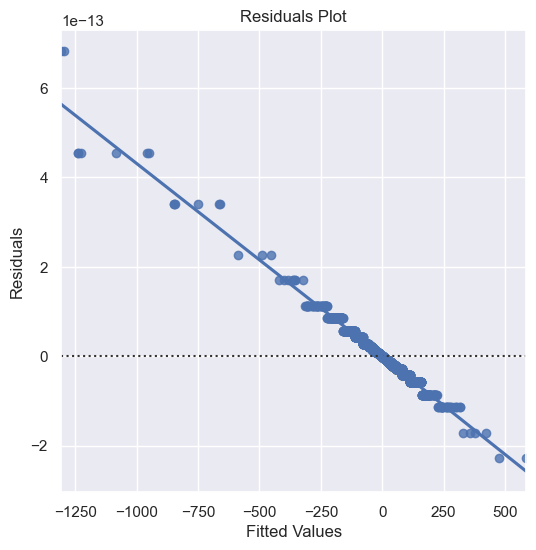

In [25]:
# Plotting 

import seaborn as sns 
import matplotlib.pyplot as plt

residuals = y_dev - preds
sns.set_theme()
plt.figure(figsize=(6,6))
sns.residplot(x=residuals, y=residuals, lowess=True)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()